# Vision Transformers (ViTClassifier)

Based on "An Image is Worth 16x16 Words: Transformers for Image Recognition at Scale", Dosovitskiy et. al.

In [14]:
from vision.transformers.attention import Attention
import torch

import pickle
import numpy as np

from torch.utils.data import Dataset, DataLoader
import torch.nn as nn 

import matplotlib.pyplot as plt

from torchvision import transforms
import wandb

In [15]:
wandb.login()

True

In [16]:
device = torch.device("mps" if torch.backends.mps.is_available() else ("cuda" if torch.cuda.is_available() else "cpu"))

In [17]:
# data boiler plate

all_batches_data = []
all_batches_labels = []

for i in range(1, 6):
    with open(f'generative/autoencoders/data/cifar-10-batches-py/data_batch_{i}', 'rb') as f:
        dataset_dict = pickle.load(f, encoding='bytes')
        all_batches_data.append(dataset_dict[b'data'])
        all_batches_labels.append(dataset_dict[b'labels'])

stacked_data = np.vstack(all_batches_data)
stacked_labels = np.hstack(all_batches_labels)
data = torch.tensor(stacked_data, dtype=torch.float32).view(-1, 3, 32, 32).to(device) / 255.
labels = torch.tensor(stacked_labels, dtype=torch.long).to(device)

split_idx = int(0.8 * len(data))

x_train, x_valid = data[:split_idx], data[split_idx:]
y_train, y_valid = labels[:split_idx], labels[split_idx:]

class CIFARCustomDataset(Dataset):
    def __init__(self, x, y, transform=None):
        self.x = x
        self.y = y
        self.transform = transform

    def __len__(self):
        return len(self.x)

    def __getitem__(self, idx):
        img, label = self.x[idx], self.y[idx]
        if self.transform:
            img = self.transform(img)
        return img, label


transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))  # CIFAR-10 stats
])

transform_val = transforms.Compose([
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
])


train_ds = CIFARCustomDataset(x_train, y_train, transform_train)
valid_ds = CIFARCustomDataset(x_valid, y_valid, transform_val)

## Creating image patches 

This function is at the heart of the ViT, transforming images to patches of images that can be treated as tokens in a sequence

In [18]:
def patchify(x: torch.Tensor, patch_size: int):
    print(x.shape)
    batch_size, channels, width, height = x.shape
    x = x.reshape(batch_size, channels, width // patch_size, patch_size, height // patch_size, patch_size)  # reshape into patches: b, c, w, h -> b, c, num_horizontal, patch_w, num_vertical, patch_h
    print(f"reshaped: {x.shape}")
    x = x.permute(0, 2, 4, 1, 3, 5)  # permute, b, c, num_horizontal, patch_w, num_vertical, patch_h -> b, num_horizontal, num_vertical, channels, patch_w, patch_h
    print(f"permuted: {x.shape}")
    return x.reshape(batch_size, -1, channels * patch_size * patch_size)  # flatten the patches

x_train_2 = patchify(x_train, 16)
x_train_2.shape

torch.Size([40000, 3, 32, 32])
reshaped: torch.Size([40000, 3, 2, 16, 2, 16])
permuted: torch.Size([40000, 2, 2, 3, 16, 16])


torch.Size([40000, 4, 768])

## Transformer related modules

In [19]:
class MLP(nn.Module): 
    """
    Class implementation of a position wise MLP
    """
    def __init__(self, d_model: int, d_ff: int, dropout: float, num_layers: int = 2) -> None:
        super(MLP, self).__init__()
        
        layers = [nn.Linear(d_model, d_ff), nn.GELU(), nn.Dropout(dropout)]
        
        for i in range(1, num_layers - 1):
            layers.append(nn.Linear(d_ff, d_ff, bias=True))
            layers.append(nn.GELU())
            layers.append(nn.Dropout(dropout))
        
        layers.append(nn.Linear(d_ff, d_model, bias=True))
        self.mlp_layers = nn.Sequential(*layers)
        
        self.layer_norm = nn.LayerNorm(d_model)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.mlp_layers(self.layer_norm(x))


class EncoderLayer(nn.Module):
    """
    Encoder layer block for ViT
    """
    def __init__(
        self, 
        num_heads: int,
        num_channels: int,
        d_linear: int,
        num_linear_layers: int = 2,
        num_groups: int = 8,
        dropout: float = 0.1,
        is_masked: bool = False
    ):
        super(EncoderLayer, self).__init__()
        self.norm1, self.norm2 = nn.LayerNorm(num_channels),  nn.LayerNorm(num_channels)
        self.mha = Attention(dropout, num_heads, num_channels, num_groups)
        self.mlp = MLP(num_channels, d_linear, dropout, num_linear_layers)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        h = self.mha(self.norm1(x)) + x
        return self.mlp(self.norm2(h)) + h


class Encoder(nn.Module):
    def __init__(
        self, 
        num_heads: int,
        num_channels: int,
        num_layers: int,
        d_linear: int,
        num_linear_layers: int = 2,
        num_groups: int = 8,
        dropout: float = 0.1,
        is_masked: bool = False
    ):
        super(Encoder, self).__init__()
        self.layers = nn.ModuleList([
            EncoderLayer(
                num_heads, num_channels, d_linear, num_linear_layers, num_groups, dropout, is_masked
            ) for _ in range(num_layers)
        ])
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        for layer in self.layers:
            x = layer(x)
        return x 

In [20]:
class MLPClassicationHead(nn.Module):
    """
    Class implementation of a position wise MLP
    """
    def __init__(
        self,
        num_classes: int,
        num_channels:int,
        d_ff: int,
        num_layers: int = 2,
        dropout: float = 0.1,
    ) -> None:
        super(MLPClassicationHead, self).__init__()

        layers = []
        layers.append(nn.Linear(num_channels, d_ff, bias=True))
        for i in range(1, num_layers - 1):
            layers.append(nn.Linear(d_ff, d_ff, bias=True))
            layers.append(nn.ReLU())
        
        layers.append(nn.Linear(d_ff, num_classes, bias=True))
        self.mlp_layers = nn.Sequential(*layers)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.mlp_layers(x)

## Putting it all together 

Whether autoregressive or bert style, transformers natively perform token prediction. The novelty in the design of the ViT is that it treats the classification task as a token prediction problem. We prepend a learnable [cls-token] (much like bert-style classifiers) that is tasked with storing representations that best enable classification (built via attention over all tokens in the context). This cls-token is the only thing fed to the classification head. So, via backprop, its objective is to provide the MLP with the best representation it can to lower classification loss. 

In [ ]:
class ViTClassifier(nn.Module):
    """
    Vision Transformer.
    """
    def __init__(
        self,
        num_classes,
        num_heads: int,
        d_model: int,
        d_mlp: int,
        patch_size: int = 16,
        image_size: tuple[int] = 32,
        num_encoder_layers: int = 2,
        encoder_mlp_depth: int = 2,
        classification_mlp_depth: int = 2,
        num_groups: int = 8,
        dropout: float = 0.1,
    ):
        super(ViTClassifier, self).__init__()
        self.d_model, self.patch_size, self.image_size = d_model, patch_size, image_size
        self.n_patches = (image_size // patch_size) ** 2  # assumes square image 
        self.linear = nn.Linear((3*patch_size*patch_size), d_model)  # assumes rgb image 
        self.encoder = Encoder(
            num_heads, d_model, num_encoder_layers, d_mlp, encoder_mlp_depth, num_groups, dropout
        )

        self.cls_token = nn.Parameter(torch.zeros(1, 1, d_model))  # assumes rgb image 
        self.classification_head = MLPClassicationHead(num_classes, d_model, d_mlp, classification_mlp_depth, dropout) # d_ff and depth are different things

        self.pos_embed = nn.Parameter(torch.zeros(1, self.n_patches + 1, d_model))
        nn.init.trunc_normal_(self.pos_embed, std=0.02)
    
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        forward pass for our vit classifier. takes in raw images and outputs a probability distribution over classes
        """
        batch_size = x.shape[0]
        x = self.linear(self._patchify(x))
        cls = self.cls_token.expand(batch_size, -1, -1)
        x = torch.cat((cls, x), 1)
        x = x + self.pos_embed[:, : x.size(1), :].to(x.device)
        x = self.encoder(x)
        return self.classification_head(x[:,0,:])
    
    def _patchify(self, x: torch.Tensor) -> torch.Tensor:
        batch_size, channels, width, height = x.shape
        n_patch_side = self.image_size // self.patch_size
        x = x.reshape(
            batch_size,
            channels,
            n_patch_side,
            self.patch_size,
            n_patch_side,
            self.patch_size
        )
        x = x.permute(0, 2, 4, 1, 3, 5)
        return x.reshape(batch_size, -1, channels * self.patch_size * self.patch_size)
        
    # Removed _positional_embedding, as we now use a learnable positional embedding


### training boiler plate 

In [9]:
def accuracy(y_pred, y):
    return (y_pred.argmax(dim=1) == y).float().mean()

def validate_model(model, valid_loader, loss_fn, all_valid_loss):
    model.eval()
    valid_loss = []
    valid_acc = []
    
    with torch.no_grad():
        for batch in valid_loader:
            x, y = batch
            y_pred = model(x)
            loss = loss_fn(y_pred, y)
            valid_loss.append(loss.item())
            valid_acc.append(accuracy(y_pred, y))
    
    all_valid_loss.append(sum(valid_loss) / len(valid_loss))
    
    return sum(valid_acc) / len(valid_acc)

def plot_loss(all_train_loss, all_valid_loss):
    plt.figure(figsize=(10, 5))
    plt.plot(all_train_loss, label='Training Loss')
    plt.plot(all_valid_loss, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()


def train_model(
    model: nn.Module,
    optim: torch.optim.Optimizer,
    loss_fn,
    train_loader: DataLoader,
    valid_loader: DataLoader,
    scheduler=None,
    epochs: int = 10,
    batch_size: int = 32,
    valid_every: int = 1
) -> None:
    """2
    Train a PyTorch model with validation.
    
    Args:
        model: The neural network model to train
        optim: The optimizer for training
        loss_fn: The loss function
        train_loader: DataLoader for training data
        valid_loader: DataLoader for validation data
        scheduler: Learning rate scheduler (optional)
        epochs: Number of training epochs (default: 10)
        batch_size: Batch size for training (default: 32)
        valid_every: Validate every N epochs (default: 1)
    
    Returns:
        None
    """
    all_train_loss = []
    all_valid_loss = []
    
    for epoch in range(epochs):
        model.train()
        train_loss = []
        
        for batch in train_loader:
            x, y = batch
            optim.zero_grad()
            y_pred = model(x)
            loss = loss_fn(y_pred, y)
            loss.backward()
            optim.step()
            train_loss.append(loss.item())
        
        all_train_loss.append(sum(train_loss) / len(train_loss))
        
        current_lr = optim.param_groups[0]['lr']
        if scheduler is not None:
            scheduler.step()
        
        if epoch % valid_every == 0:
            valid_acc = validate_model(model, valid_loader, loss_fn, all_valid_loss)
            print(
                f"Epoch {epoch}, Train Loss: {sum(train_loss) / len(train_loss)}, "
                f"Valid Loss: {all_valid_loss[-1]}, "
                f"Acc: {valid_acc}"
            )
            wandb.log({
                "epoch": epoch,
                "train_loss": all_train_loss[-1],
                "valid_loss": all_valid_loss[-1],
                "valid_accuracy": valid_acc,
                "learning_rate": current_lr
            })
    
    plot_loss(all_train_loss, all_valid_loss)

In [ ]:
d_model = 256
d_mlp = 512
num_encoder_layers = 4
patch_size = 4
dropout = 0.3

model = ViTClassifier(num_classes=10, num_heads=4, d_model=d_model, d_mlp=d_mlp, num_encoder_layers=num_encoder_layers, patch_size=patch_size, dropout=dropout).to(device)
num_params = sum(p.numel() for p in model.parameters())
print(f"Number of parameters in model: {num_params}")


Number of parameters in model: 5433610


Epoch 0, Train Loss: 2.011571117594272, Valid Loss: 1.8563194930553437, Acc: 0.31027689576148987
Epoch 1, Train Loss: 1.7939664487597309, Valid Loss: 1.7235060334205627, Acc: 0.37124308943748474
Epoch 2, Train Loss: 1.666852113566821, Valid Loss: 1.6239006459712981, Acc: 0.4086742103099823
Epoch 3, Train Loss: 1.578789628004726, Valid Loss: 1.5321803331375121, Acc: 0.44788026809692383
Epoch 4, Train Loss: 1.5089813455750671, Valid Loss: 1.478570705652237, Acc: 0.47521254420280457
Epoch 5, Train Loss: 1.4521547601192812, Valid Loss: 1.4517551481723785, Acc: 0.477826327085495
Epoch 6, Train Loss: 1.4133451543276823, Valid Loss: 1.3860924243927002, Acc: 0.5051586031913757
Epoch 7, Train Loss: 1.3784221290033074, Valid Loss: 1.2961691200733185, Acc: 0.532065749168396
Epoch 8, Train Loss: 1.337373063534121, Valid Loss: 1.2954424560070037, Acc: 0.5342486500740051
Epoch 9, Train Loss: 1.3054288459729544, Valid Loss: 1.2659447014331817, Acc: 0.5433306694030762
Epoch 10, Train Loss: 1.288232201

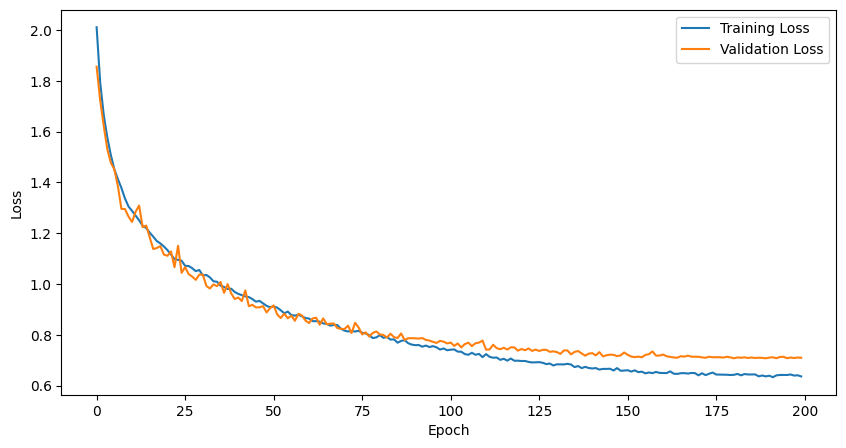

wandb: ERROR The nbformat package was not found. It is required to save notebook history.


epoch,▁▁▁▂▂▂▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇▇▇███
learning_rate,█████▇▇▇▇▇▇▇▆▆▆▆▅▅▄▄▄▄▄▄▄▃▃▂▂▂▂▂▂▂▂▁▁▁▁▁
train_loss,█▆▅▅▄▄▄▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
valid_accuracy,▁▂▄▄▅▆▆▇▇▇▇▇▇▇▇▇▇███████████████████████
valid_loss,█▇▇▅▅▄▄▄▃▃▃▃▂▂▂▂▂▂▂▂▂▂▁▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,199
learning_rate,0.0
train_loss,0.63614
valid_accuracy,0.75928
valid_loss,0.70948


In [ ]:
epochs = 200
batch_size = 512
optim = torch.optim.AdamW(model.parameters(), lr=3e-4, weight_decay=0.1)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
    optim, T_max=epochs
)
loss_fn = nn.CrossEntropyLoss()

wandb.init(
    project="aryaman_wandb_setup", # Project name
    config={
        "learning_rate": 1e-4,
        "architecture": "ViT",
        "dataset": "CIFAR-10",
        "epochs": epochs,
        "batch_size": batch_size,
        "d_model": model.d_model,
        "d_mlp": d_mlp, # You can get this from your model def
        "num_encoder_layers": num_encoder_layers, # You can get this from your model def
        "patch_size": model.patch_size,
        "dropout": dropout, # You can get this from your model def
        "optimizer": "AdamW",
        "weight_decay": 0.1,
        "lr_scheduler": "ExponentialLR",
        "gamma": 0.9
    }
)

wandb.watch(model, log='all', log_freq=100)

train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
valid_dl = DataLoader(valid_ds, batch_size=batch_size, shuffle=True)

train_model(model, optim, loss_fn, train_dl, valid_dl, scheduler=scheduler, epochs=epochs, valid_every=1)

wandb.finish()

Things that have helped classification accuracy:
- higher dropout p, reduces overfitting 
- more aggressive dropout strategy: per layer in the MLP, also reduces early overfitting and helps lower val loss 
- lowering patch size from 16 -> 8 -> 4 -> 2 all showed some improvement in accuracy and validation loss, albeit training speed reduces with each patch size drop
- Increasing transformer depth and num heads. Going from num_heads = 4 and encoder_depth = 3 to num_heads = 8, encoder_depth = 6 leads to good results